<a href="https://colab.research.google.com/github/agojunior/cap-423/blob/main/ANTONIONEUROGEOINFO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wtss
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install io
!pip install requests
!pip install tqdm
!pip install tensorflow
import wtss
import pandas as pd
import geopandas as gpd
import numpy as np
import io, requests
import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN

from tensorflow.keras.layers import Dropout
import requests


ERROR: Could not find a version that satisfies the requirement io (from versions: none)
ERROR: No matching distribution found for io


In [ ]:
rng = np.random.default_rng(20241217)

In [ ]:
base_dir = '/home/junior/'
#Arquivo contendo localização geoespaciais, e a classificação de uso e cobertura da terra daquele local. Temos interesse especial na vegetação arbustiva, por se tratar de amostras do mangue vermelho, e na vegetação herbacea, por ser amostrar de mangue branco
pontos_path = base_dir + 'amostras_mangue.csv'
df = pd.read_csv('/content/amostras_mangue.csv')
print(df.axes)
# long / lat columns to geodataframe geomtry all other columns attributes
pontos = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"), data=df
)

[RangeIndex(start=0, stop=337, step=1), Index(['geometry', 'label_id', 'label_name', 'label', 'collection_date',
       'created_at', 'end_date', 'id', 'start_date', 'updated_at',
       'user_email', 'user_name', 'longitude', 'latitude'],
      dtype='object')]


In [ ]:
# pontos = gpd.read_file(pontos_path)

In [ ]:
# pontos = pontos.groupby('label', group_keys=False).apply(lambda x: x.sample(
#     frac=0.20, random_state=rng))

In [ ]:
df = pd.read_csv('/content/amostras_mangue.csv')
pontos = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"), data=df
)
pontos.head()

,geometry,label_id,label_name,label,collection_date,created_at,end_date,id,start_date,updated_at,user_email,user_name,longitude,latitude
0,POINT (-44.54454 -3.00034),265,vegetação-arbutiva-arbórea,Vegetação arbustiva/arbórea,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,4,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.544539,-3.000342
1,POINT (-44.53551 -2.99893),272,corpo-d’água,Corpos d’água,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,5,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.535506,-2.998927
2,POINT (-44.24047 -2.99819),274,superfície-artificiai,Superfícies artificiais,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,6,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.240474,-2.998193
3,POINT (-44.43395 -2.89332),272,corpo-d’água,Corpos d’água,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,7,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.433947,-2.893324
4,POINT (-44.40708 -2.90055),265,vegetação-arbutiva-arbórea,Vegetação arbustiva/arbórea,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,8,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.407082,-2.900546


In [ ]:
groundTruth = pd.DataFrame({
    'id': np.asarray(pontos.id.values),
    'classification': np.asarray(pontos.label_name).T
})

# Save the DataFrame to a CSV file
groundTruth.to_csv('label2.csv', index=False)


In [ ]:
servico = wtss.WTSS('https://data.inpe.br/bdc/wtss/v4/')
cubo_s2 = servico['S2-16D-2']
start_date = '2023-06-01'
end_date = '2024-06-30'


attributes = ('B8A','B11','B04','NDVI')

In [ ]:
timeline = cubo_s2.timeline

ultima_data_disponivel = timeline[0]
primeira_data_disponivel = timeline[-1]

print(f'Intervalo: [{primeira_data_disponivel}, {ultima_data_disponivel}]')

Intervalo: [2024-09-29, 2018-01-01]


In [ ]:
start_date = '2023-06-01'
end_date = '2024-06-30'


attributes = ('B8A','B11','B04','NDVI', 'SCL')

# attributes = ('NDVI', 'SCL')

In [ ]:

# 'B8A','B11','B04','NDVI'
b8a_values = []
b11_values = []
b04_values = []
ndvi_values = []
scl_values = []
time_values = []
for id, geometry in tqdm.tqdm(zip(pontos.id.values,
                                  pontos.geometry.values),
                         desc="Processando dados", unit="data"):
  timeseries = cubo_s2.ts(attributes=attributes,
                            longitude=geometry.x,
                            latitude=geometry.y,
                            start_date=start_date,
                            end_date=end_date)

  # response = requests.get("http://www.worldtides.info/api/v3", params={"q": "language:python", "sort": "stars", "order": "desc"})
  time_values.append(timeseries.timeline)
  ndvi_values.append(timeseries.values('NDVI'))
  b11_values.append(timeseries.values('B11'))
  b04_values.append(timeseries.values('B04'))
  b8a_values.append(timeseries.values('B8A'))
  scl_values.append(timeseries.values('SCL'))

Processando dados: 331data [06:06,  1.18s/data]

In [ ]:
pip install earthengine-api

In [ ]:
import ee
import pandas as pd
import os

# Initialize Google Earth Engine
ee.Initialize(project='antonio-oliveira-inpe-24')

# Load the CSV with the coordinates (assuming you have downloaded the CSV file from the previous step)
csv_file_path = 'geospatial_data_with_final_centroids.csv'  # Path to your CSV file
locations_df = pd.read_csv(csv_file_path)
locations_df = locations_df.sample(frac=0.001, random_state=1)
print(len(locations_df))

EEException: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.

In [ ]:
ee.Authenticate()

In [ ]:
ndvi = pd.DataFrame(data=np.asarray(ndvi_values).T,
                    columns=pontos.id.astype(str).values,  # Converte IDs para string
                    index=timeseries.timeline)

# Restaura o índice e renomeia a coluna de data
ndvi = ndvi.reset_index().rename(columns={'index': 'data'})

# Salva o DataFrame em um arquivo CSV
ndvi.to_csv('ndvi_sample.csv', index=False)

In [ ]:
scl = pd.DataFrame(data=np.asarray(scl_values).T,
                    columns=pontos.id.astype(str).values,  # Converte IDs para string
                    index=timeseries.timeline)

# Restaura o índice e renomeia a coluna de data
scl = scl.reset_index().rename(columns={'index': 'data'})

# Salva o DataFrame em um arquivo CSV
scl.to_csv('scl_sample.csv', index=False)

In [ ]:
b8a = pd.DataFrame(data=np.asarray(b8a_values).T,
                    columns=pontos.id.astype(str).values,  # Converte IDs para string
                    index=timeseries.timeline)


b8a = b8a.reset_index().rename(columns={'index': 'data'})
b8a.to_csv('b8a_sample.csv')

In [ ]:
b11 = pd.DataFrame(data = np.asarray(b11_values).T,
                    columns=pontos.id.values,
                    index=timeseries.timeline)

b11 = b11.reset_index().rename(columns={'index': 'data'})
b11.to_csv('b11_sample.csv')

In [ ]:
b04 = pd.DataFrame(data = np.asarray(b04_values).T,
                    columns=pontos.id.values,
                    index=timeseries.timeline)

b04 = b04.reset_index().rename(columns={'index': 'data'})
b04.to_csv('b04_sample.csv')

In [ ]:
b09 = pd.DataFrame(data = np.asarray(b04_values).T,
                    columns=pontos.latitude.values,
                    index=timeseries.timeline)

b09 = b09.reset_index().rename(columns={'index': 'data'})
b09.to_csv('b09_sample.csv')

In [ ]:
pontos.latitude.values

array([-3.000342, -2.998927, -2.998193, -2.893324, -2.900546, -2.98216 ,
       -2.518662, -2.51952 , -2.526551, -2.530667, -2.696491, -2.701292,
       -2.679344, -2.718439, -2.711237, -2.71741 , -2.436514, -2.423136,
       -2.413188, -2.463611, -2.432397, -2.791139, -2.784624, -2.866235,
       -2.735929, -3.015727, -2.820973, -2.954013, -2.856634, -1.389634,
       -1.428761, -1.429448, -1.480243, -1.384829, -1.491226, -1.130832,
       -1.165844, -1.215271, -1.250282, -1.250282, -1.20772 , -1.196736,
       -1.196736, -1.209093, -1.265385, -1.284606, -1.307946, -1.197423,
       -1.305887, -1.309319, -1.329226, -1.223509, -1.206347, -1.193304,
       -1.195363, -1.167217, -1.126713, -1.178887, -1.207034, -1.19399 ,
       -1.152114, -1.492942, -1.486421, -1.48848 , -1.49706 , -1.491569,
       -1.492255, -1.5077  , -1.520741, -1.46068 , -1.446952, -1.528978,
       -1.538588, -1.531037, -1.528978, -1.535156, -1.451757, -1.472692,
       -1.480243, -1.484018, -1.484018, -1.490882, 

In [ ]:
# tides = []
# for t in timeseries.timeline:
#   for p in pontos.latitude.values:
#     response = requests.get("http://www.worldtides.info/api/v3", params={"lat":str(p),"date":str(t)})
#     print(response)
#     tides.append(response)

<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>
<Response [400]>


KeyboardInterrupt: 

In [ ]:
pontos.latitude.values

array([-3.000342, -2.998927, -2.998193, -2.893324, -2.900546, -2.98216 ,
       -2.518662, -2.51952 , -2.526551, -2.530667, -2.696491, -2.701292,
       -2.679344, -2.718439, -2.711237, -2.71741 , -2.436514, -2.423136,
       -2.413188, -2.463611, -2.432397, -2.791139, -2.784624, -2.866235,
       -2.735929, -3.015727, -2.820973, -2.954013, -2.856634, -1.389634,
       -1.428761, -1.429448, -1.480243, -1.384829, -1.491226, -1.130832,
       -1.165844, -1.215271, -1.250282, -1.250282, -1.20772 , -1.196736,
       -1.196736, -1.209093, -1.265385, -1.284606, -1.307946, -1.197423,
       -1.305887, -1.309319, -1.329226, -1.223509, -1.206347, -1.193304,
       -1.195363, -1.167217, -1.126713, -1.178887, -1.207034, -1.19399 ,
       -1.152114, -1.492942, -1.486421, -1.48848 , -1.49706 , -1.491569,
       -1.492255, -1.5077  , -1.520741, -1.46068 , -1.446952, -1.528978,
       -1.538588, -1.531037, -1.528978, -1.535156, -1.451757, -1.472692,
       -1.480243, -1.484018, -1.484018, -1.490882, 

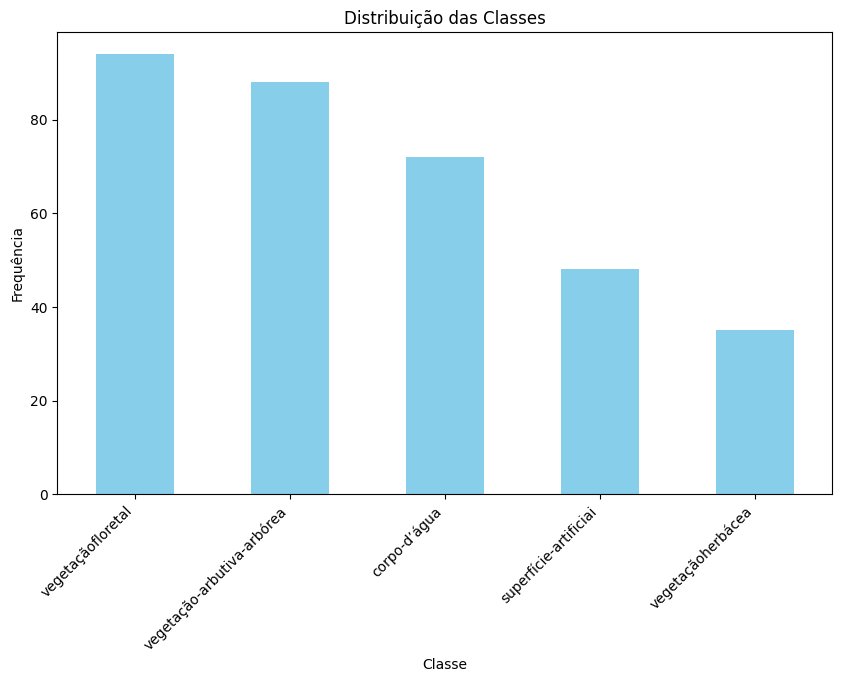

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho do arquivo CSV de classificação
classification_path = 'label2.csv'

# Carregar os dados de classificação
classification = pd.read_csv(classification_path)

# Contar a frequência de cada classe
class_counts = classification['classification'].value_counts()

# Plotar o histograma
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'
ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])

X = final_data_filtered[['ndvi', 'b8a', 'b4', 'b11']]
y = (final_data_filtered['classification']
              .apply(lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else 0)).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


ValueError: You are trying to merge on object and int64 columns for key 'data'. If you wish to proceed you should use pd.concat

In [ ]:
ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'
ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])
final_data_filtered.to_csv('final_data.csv', index=False)

In [ ]:
ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'
ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])

X = final_data_filtered[['ndvi', 'b8a', 'b4', 'b11']]
y = (final_data_filtered['classification'].apply(lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else 0)).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


In [ ]:
model.summary()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7199 - loss: 0.6872 - val_accuracy: 0.7472 - val_loss: 0.6689
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7378 - loss: 0.6649 - val_accuracy: 0.7472 - val_loss: 0.6489
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7139 - loss: 0.6517 - val_accuracy: 0.7472 - val_loss: 0.6322
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7259 - loss: 0.6351 - val_accuracy: 0.7472 - val_loss: 0.6187
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7291 - loss: 0.6228 - val_accuracy: 0.7472 - val_loss: 0.6075
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7206 - loss: 0.6173 - val_accuracy: 0.7472 - val_loss: 0.5986
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7394 - loss: 0.6008 - val_accuracy: 0.7472 - val_loss: 0.5914
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7479 - loss: 0.5896 - val_accuracy: 0.7472 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


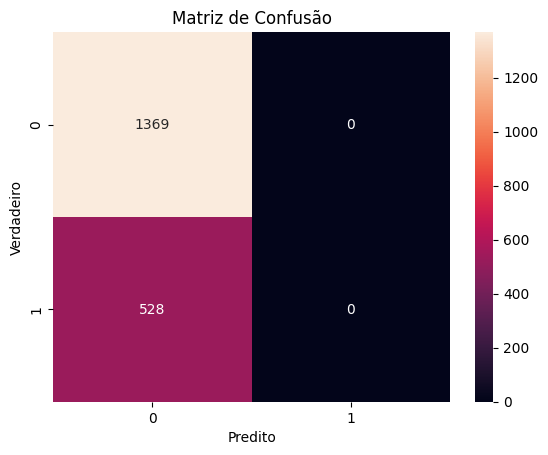

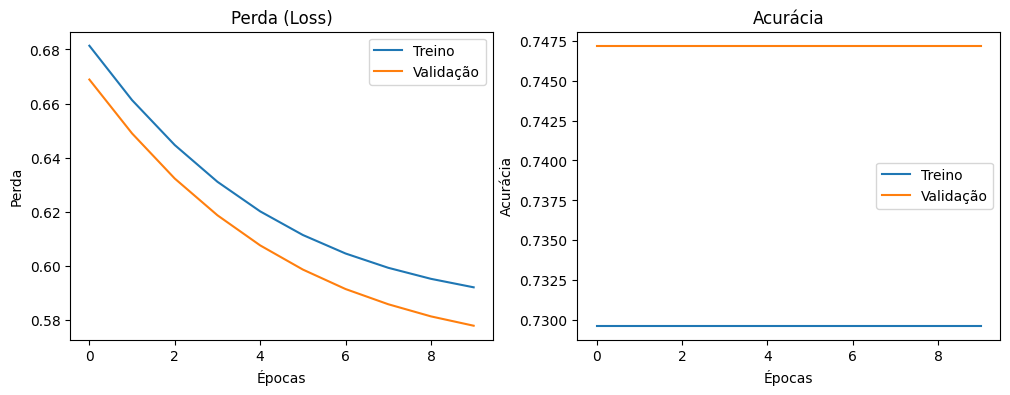

In [ ]:
ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'
ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])

X = final_data_filtered[['ndvi', 'b8a', 'b4', 'b11']]
y = (final_data_filtered['classification']
              .apply(lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else 0)).values


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = Sequential()
input_dim = X_train.shape[1]
model.add(Dense(4, input_dim=input_dim, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
# Adicionar a camada de saída com 1 neurônio (saída binária) e ativação sigmoid para classificação binária
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


In [ ]:

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (648.00 B)

 Trainable params: 53 (212.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108 (436.00 B)

#Testando modelos mais profundos

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7166 - loss: 0.6384 - val_accuracy: 0.7472 - val_loss: 0.5612
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7279 - loss: 0.5639 - val_accuracy: 0.7472 - val_loss: 0.5121
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7256 - loss: 0.5137 - val_accuracy: 0.7472 - val_loss: 0.4852
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7261 - loss: 0.5102 - val_accuracy: 0.8194 - val_loss: 0.4798
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7593 - loss: 0.4672 - val_accuracy: 0.7935 - val_loss: 0.4087
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7969 - loss: 0.4337 - val_accuracy: 0.8397 - val_loss: 0.3936
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8371 - loss: 0.3915 - val_accuracy: 0.8420 - val_loss: 0.3726
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8320 - loss: 0.3889 - val_accu

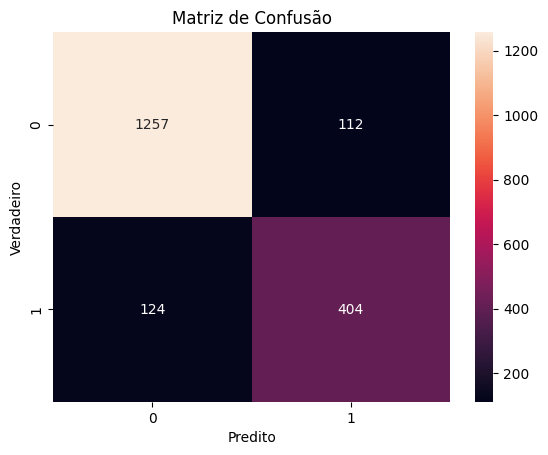

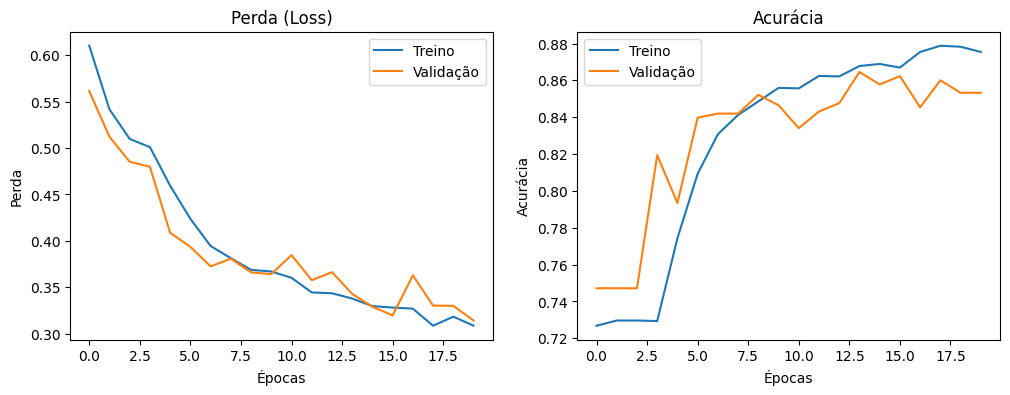

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 4, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 4, 100)              │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,005 (1.76 MB)

 Trainable params: 154,001 (601.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,004 (1.17 MB)

In [ ]:


ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'
ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])

X = final_data_filtered[['ndvi', 'b8a', 'b4', 'b11']]
y = (final_data_filtered['classification']
              .apply(lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else 0)).values


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
model = Sequential()

# Primeira camada LSTM
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout para evitar overfitting

# Segunda camada LSTM
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Terceira camada LSTM
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))

# Camada densa final para a classificação
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=20, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

model.summary()

In [ ]:


ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'
ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])

X = final_data_filtered[['ndvi', 'b8a', 'b4', 'b11']]
y = (final_data_filtered['classification']
              .apply(lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else 0)).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = Sequential()
input_dim = X_train.shape[1]
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# Adicionar a camada de saída com 1 neurônio (saída binária) e ativação sigmoid para classificação binária
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo com os dados de entrada X_train e as labels y_train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


ValueError: You are trying to merge on object and int64 columns for key 'data'. If you wish to proceed you should use pd.concat

In [ ]:


ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'
ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])

y = final_data_filtered['classification'].apply(
    lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else (0 if x == 'vegetaçãoherbácea' else 2)
)

# Filtrar as linhas onde y é None (remover outras classes)
filtered_data = final_data_filtered[y.notnull()]
X = filtered_data[['ndvi', 'b8a', 'b4', 'b11']]
y = filtered_data['classification'].apply(lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else (0 if x == 'vegetaçãoherbácea' else 2)).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = Sequential()
input_dim = X_train.shape[1]
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# Adicionar a camada de saída com 1 neurônio (saída binária) e ativação sigmoid para classificação binária
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo com os dados de entrada X_train e as labels y_train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


ValueError: You are trying to merge on object and int64 columns for key 'data'. If you wish to proceed you should use pd.concat

KeyboardInterrupt: 

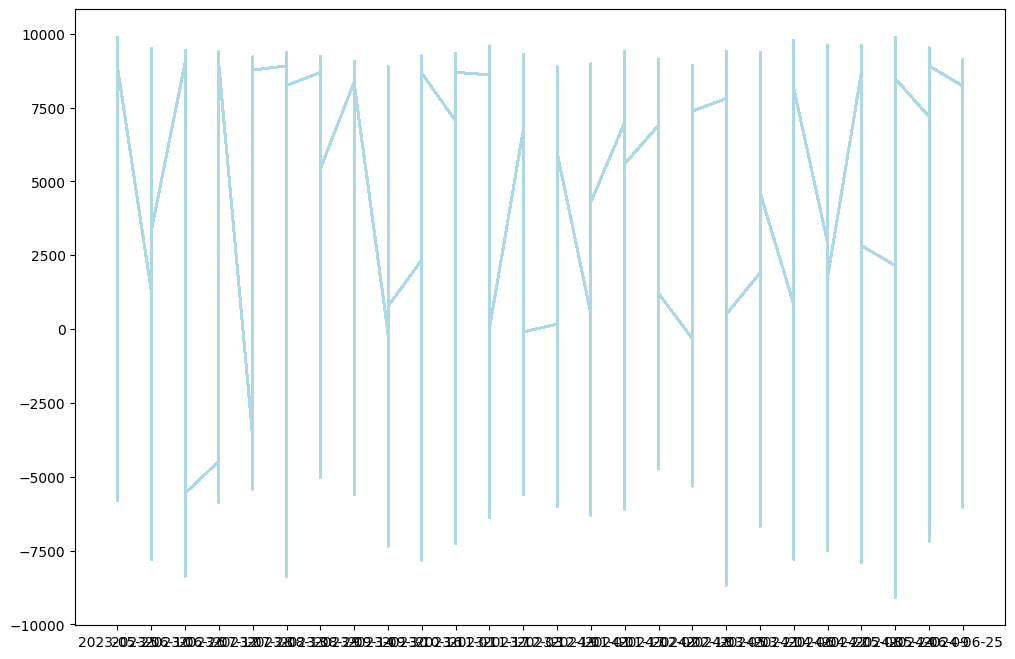

In [ ]:
# Adjusting the plot to match the style seen in the provided image

def plot_adjusted_spectral_band(data, band):
    # Sort the data by date
    data_sorted = data.sort_values(by='data')

    # Calculate median and interquartile ranges (IQR)
    median = data_sorted.groupby('data')[band].median()
    q1 = data_sorted.groupby('data')[band].quantile(0.25)
    q3 = data_sorted.groupby('data')[band].quantile(0.75)

    plt.figure(figsize=(12, 8))

    # Plot each sample as faint blue lines
    for i in range(len(data_sorted[band].unique())):
        plt.plot(data_sorted['data'], data_sorted[band], color='lightblue', alpha=0.3)

    # Plot the median as a strong red line
    plt.plot(median.index, median.values, color='brown', linewidth=3, label='Median')

    # Plot the IQR range with yellow lines
    plt.plot(q1.index, q1.values, color='goldenrod', linestyle='-', linewidth=2, label='First IQR')
    plt.plot(q3.index, q3.values, color='goldenrod', linestyle='-', linewidth=2, label='Third IQR')

    # Aesthetic adjustments similar to the image
    plt.title(f'Samples for class in band = {band.upper()}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{band.upper()} Value', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.show()

# Adjust plot for NDVI band
plot_adjusted_spectral_band(final_data, 'ndvi')
# Re-loading the final_data.csv as it was cleared
import pandas as pd
import matplotlib.pyplot as plt

# Load the final_data.csv file again
final_data_path = '/mnt/data/final_data.csv'
final_data = pd.read_csv(final_data_path)

# Convert the 'data' column to datetime format for proper handling of temporal data
final_data['data'] = pd.to_datetime(final_data['data'])

# Reattempting the plot with the updated data
plot_adjusted_spectral_band(final_data, 'ndvi')


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,837 (34.52 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,892 (23.02 KB)